In [1]:
#TODO
# Make evolving_static_static_static_lakes_gdf of evolving outlines unary unions (lake_locations notebook)
# Fix compare_outline_complexity to use geodesic area
# Simplify calculate area, compare_outline_complexity, and find_max_area_bias to read in evolving_lakes_gdf
# Use calculate_area function in lake_locations notebook?

In [2]:
# Code to Fig. 2 of Sauthoff and others, 2024
# This code requires a XX GB server or local memory
#
# Written 2023-11-11 by W. Sauthoff (wsauthoff.github.io)

# Set up computing environment

In [3]:
# Import libraries
import datetime
# import earthaccess
# import fiona
import geopandas as gpd
import glob
# from IPython.display import clear_output
import matplotlib
# import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.legend_handler import HandlerTuple
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
# from os import path
import pandas as pd
from pyproj import CRS, Geod, Transformer
import rioxarray
# from rioxarray.exceptions import NoDataInBounds
from shapely.geometry import MultiPolygon, Point, Polygon
from shapely.ops import unary_union
# from skimage import measure
# import xarray as xr

# Magic functions
%matplotlib widget

# from IPython.display import Audio, display
# def play_sound():
#     display(Audio(url="http://codeskulptor-demos.commondatastorage.googleapis.com/pang/pop.mp3", autoplay=True))

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/Fig2_lake_reexamination.ipynb'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer
geod = Geod(ellps="WGS84") # Create a Geod object for calculating area on the WGS84 ellipsoid

# # Change default font to increase font size
# plt.rcParams.update({'font.size': 8})

# Functions

In [4]:
# def timestamp_to_fractional_year(timestamp):
#     # Check if the year is a leap year
#     year = timestamp.year
#     if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
#         days_in_year = 366
#     else:
#         days_in_year = 365

#     # Calculate the day of the year
#     day_of_year = timestamp.timetuple().tm_yday

#     # Calculate the fractional year
#     fractional_year = year + (day_of_year - 1) / days_in_year
    
#     return fractional_year

# # # Example usage
# # timestamp = pd.Timestamp('2023-03-07 12:34:56')
# # fractional_year = timestamp_to_fractional_year(timestamp)
# # print(f"Fractional Year: {fractional_year}")

In [5]:
def compare_outline_complexity(lake_gdf):
    '''
    Calculate the perimeter-to-area ratio for a given lake in both the static outline and the 
    unary union of evovling outlines
    '''
    lake_name = lake_gdf['name'].iloc[0]
    static_outline = lake_gdf['geometry'].iloc[0]

    # Attempt to open evolving outlines geojson
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except Exception as e:  # Using a general exception to catch all file and driver errors
        print(f"File for {lake_name} not found or error reading file: {e}")
        return None

    # Create evolving outlines unary union
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))

    # Calculating complexity - perimeter-to-area ratio
    static_complexity = static_outline.length / static_outline.area
    evolving_complexity = evolving_outlines_unary_union.length / evolving_outlines_unary_union.area
    complexity_ratio = evolving_complexity / static_complexity
    
    return {
        'lake_name': lake_name,
        'static_complexity': static_complexity,
        'evolving_complexity': evolving_complexity,
        'complexity_ratio': complexity_ratio
    }

In [6]:
def calculate_area(poly):
    '''
    Calculate geodesic are of polygon or multipolygon
    '''
    if poly is None or not poly.is_valid:
        return None
    if isinstance(poly, Polygon):
        return abs(geod.polygon_area_perimeter(poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0])
    elif isinstance(poly, MultiPolygon):
        total_area = 0
        for part in poly.geoms:  # Ensure we're accessing the geometries properly
            total_area += abs(geod.polygon_area_perimeter(part.exterior.coords.xy[0], part.exterior.coords.xy[1])[0])
        return total_area

In [7]:
def find_max_area_bias(lake_gdf):
    '''

    '''
    lake_name = lake_gdf['name'].iloc[0]

    # Attempt to open evolving outlines geojson
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except Exception as e:  # Using a general exception to catch all file and driver errors
        # print(f"File for {lake_name} not found or error reading file: {e}")
        return None
        
    # Attempt to open the geometric calculations CSV file
    try:
        geom_calcs_df = pd.read_csv(os.path.join(
            os.getcwd(), 'output/lake_outlines/compare_evolving_and_static_outlines/{}.csv'.format(lake_name)))
    except FileNotFoundError:
        # print(f"CSV file for {lake_name} not found. Skipping...")
        return  # Skip the rest of the function if the file doesn't exist

    # Find max area bias
    max_bias_area = max(geom_calcs_df['bias_area (m^2)'])
    
    # Create evolving outlines unary union
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
    evolving_outlines_unary_union_gdf = gpd.GeoDataFrame(geometry=[evolving_outlines_unary_union], crs='3031')

    # Convert GeoDataFrame to EPSG:4326 for geodesic area calculation
    evolving_outlines_unary_union_gdf = evolving_outlines_unary_union_gdf.to_crs('4326')
    
    # Calculate the geodesic area for each polygon
    evolving_outlines_unary_union_gdf['area (m^2)'] = evolving_outlines_unary_union_gdf['geometry'].apply(calculate_area)

    # Find area difference between static outline and evolving outlines unary union
    evolving_union_static_diff = evolving_outlines_unary_union_gdf['area (m^2)'].iloc[0] - lake_gdf['area (m^2)'].iloc[0]
    
    return {
        'lake_name': lake_name,
        'max_bias_area': max_bias_area,
        'evolving_union_static_diff': evolving_union_static_diff
    }

In [8]:
def muliple_area_buffer(polygon, area_multiple, precision=100):
    """
    This function takes a polygon and returns a polygon with a buffer such that the area of the buffered polygon
    is approximately the specified multiple the area of the original polygon.

    :param polygon: Shapely Polygon object
    :param area_multiple: the multiple of the original polygon area you wish the buffered polygon to be
    :param precision: Precision for the iterative process to find the buffer distance
    :return: Buffered Polygon
    """
    original_area = polygon.area
    target_area = area_multiple * original_area
    buffer_distance = 0
    buffered_polygon = polygon

    while True:
        buffered_polygon = polygon.buffer(buffer_distance)
        if buffered_polygon.area >= target_area:
            break
        buffer_distance += precision
    
    # Convert to geodataframe
    buffered_polygon_gdf = gpd.GeoDataFrame({'geometry': [buffered_polygon]})

    return buffered_polygon

# # Example usage
# # Define a simple square polygon
# square = Polygon([(0, 0), (1, 0), (1, 1), (0, 1)])
# # Apply the function to find the buffered polygon area and bounds
# buffered_poly = muliple_area_buffer(square, 2)

# Import datasets

In [9]:
# Import subglacial lake outlines 
S09_outlines = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/S09_outlines.geojson')
SF18_outlines = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/SF18_outlines.geojson')
SF18_outlines_SF18only = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/SF18_outlines_SF18only.geojson')
static_lakes_gdf = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/static_lakes_gdf.geojson')
static_lakes_gdf_postSF18 = gpd.read_file('/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./output/lake_outlines/static_outlines/static_lakes_gdf_postSF18.geojson')

In [10]:
# Import MODIS Mosaic of Antarctica (MOA) surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir
# Open into an xarray.DataArray
# moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
# moa_lowres_da = rioxarray.open_rasterio(moa_lowres)

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 
moa_highres_da = rioxarray.open_rasterio(moa_highres)

Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:Incorrect value for "GeoKeyDirectory"; tag ignored
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations


In [11]:
# MODIS MOA 2014 coastline and grounding line
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp, crs=3031)
# moa_2014_groundingline['geometry'] = moa_2014_groundingline.buffer(0)

In [12]:
# Import CryoSat-2 SARIn mode mask
# See 0_preprocess_data.ipynb for data source and pre-processing steps
gdf_SARIn_3_1 = gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson')
gdf_SARIn_3_1_3_6_diff= gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson')

In [13]:
cyc_dates = pd.read_csv('output/cycle_dates.csv', parse_dates=['cyc_start_dates', 'midcyc_dates', 'cyc_end_dates'])

# Statistics used in results section

In [14]:
# Combine all the evolving/static geometric calculation dataframes together to look at all time slices of all lakes that exhibit evolving outlines

# Replace 'your_folder_path' with the path to your folder containing GeoJSON files
directory = 'output/lake_outlines/compare_evolving_and_static_outlines' #/home/jovyan/1_outlines_candidates/Sauthoff-2025-J.Glaciol./

# Initialize an empty list to store the DataFrames
dataframes = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    # Check if the file is a CSV and not the file to ignore
    if filename.endswith('.csv') and filename != 'all_previously_identified_lakes.csv':  # Ignore summation dataframe
        file_path = os.path.join(directory, filename)  # Get full path of the file
        df = pd.read_csv(file_path)  # Read the CSV file into a DataFrame
        df['lake_name'] = filename[:-4]  # Remove the .csv extension
        dataframes.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into one DataFrame
all_compare_evolving_and_static_outlines_df = pd.concat(dataframes, ignore_index=True)

In [15]:
# Import the evolving/static geometric calculation dataframes aggregated by timeslice for continentally integrated numbers
file_path = 'output/lake_outlines/compare_evolving_and_static_outlines/all_CS2_IS2_lakes_spatially_integrated.csv'
all_CS2_IS2_lakes_spatially_integrated_df = pd.read_csv(file_path)

file_path = 'output/lake_outlines/compare_evolving_and_static_outlines/all_IS2_lakes_spatially_integrated.csv'
all_IS2_lakes_spatially_integrated_df = pd.read_csv(file_path)

## Evolving outlines

In [39]:
# How many previously identified lakes were analyzed?
len(static_lakes_gdf)

150

In [10]:
# How many lakes are missing CryoSat-2 SARIn coverage?
len(static_lakes_gdf[static_lakes_gdf['CS2_SARIn_time_period'] == 'nan'])

98

In [11]:
# How many lakes are missing CryoSat-2 SARIn coverage during 2010.5-2013.75?
len(static_lakes_gdf[static_lakes_gdf['CS2_SARIn_time_period'] == '2013.75-2018.75'])

6

In [12]:
# How many lakes are have complete CryoSat-2 SARIn coverage during pre-ICESat-2 era (2010.5-2018.75)?
len(static_lakes_gdf[static_lakes_gdf['CS2_SARIn_time_period'] == '2010.5-2018.75'])

46

In [13]:
# How many lakes exhibit no evolving outlines?
len(os.listdir('output/lake_outlines/evolving_outlines')) - len(os.listdir('output/lake_outlines/compare_evolving_and_static_outlines'))

16

In [15]:
# Find names of lakes that do not have evolving outlines during the observational period

# Define the directories to compare
dir1 = 'output/lake_outlines/evolving_outlines'
dir2 = 'output/lake_outlines/compare_evolving_and_static_outlines'

# Helper function to get filenames without extensions
def filenames_without_extension(directory):
    return {os.path.splitext(file)[0] for file in os.listdir(directory)}

# List filenames in both directories without extensions
files_in_dir1 = filenames_without_extension(dir1)
files_in_dir2 = filenames_without_extension(dir2)

# Find files that are in dir1 but not in dir2
unique_to_dir1 = files_in_dir1.difference(files_in_dir2)

# Find files that are in dir2 but not in dir1
unique_to_dir2 = files_in_dir2.difference(files_in_dir1)

# Display the results
print("{} files unique to {}:".format(len(unique_to_dir1), dir1))
for file in unique_to_dir1:
    print(file)

print("\nFiles unique to {}:".format(dir2))
for file in unique_to_dir2:
    print(file)

17 files unique to output/lake_outlines/evolving_outlines:
Bindschadler_1
U2
Foundation_4
Kamb_4
Mertz_1
Mulock_1
U1
KT3
Byrd_s3
EAP_4
Foundation_1
Ninnis_2
JG_Combined_D2_b_E1
Wilkes_1
JG_D1_a
Institute_W1
Nimrod_1

Files unique to output/lake_outlines/compare_evolving_and_static_outlines:
all_previously_identified_lakes
.ipynb_checkpoints


In [17]:
# What kind of CryoSat-2 SARIn coverage do these lakes have?
static_lakes_gdf[static_lakes_gdf['name'].isin(unique_to_dir1)]['CS2_SARIn_time_period']

0                  nan
16                 nan
35                 nan
42     2013.75-2018.75
52                 nan
63     2013.75-2018.75
65      2010.5-2018.75
67      2010.5-2018.75
73      2010.5-2018.75
80                 nan
101                nan
102                nan
103                nan
106     2010.5-2018.75
138                nan
139                nan
148     2010.5-2018.75
Name: CS2_SARIn_time_period, dtype: object

In [ ]:
# Compare lake outline complexity between evolving outlines union and static outline
results = []

for idx, row in static_lakes_gdf.iterrows():
    result = compare_outline_complexity(static_lakes_gdf.loc[[idx]])
    if result:
        results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

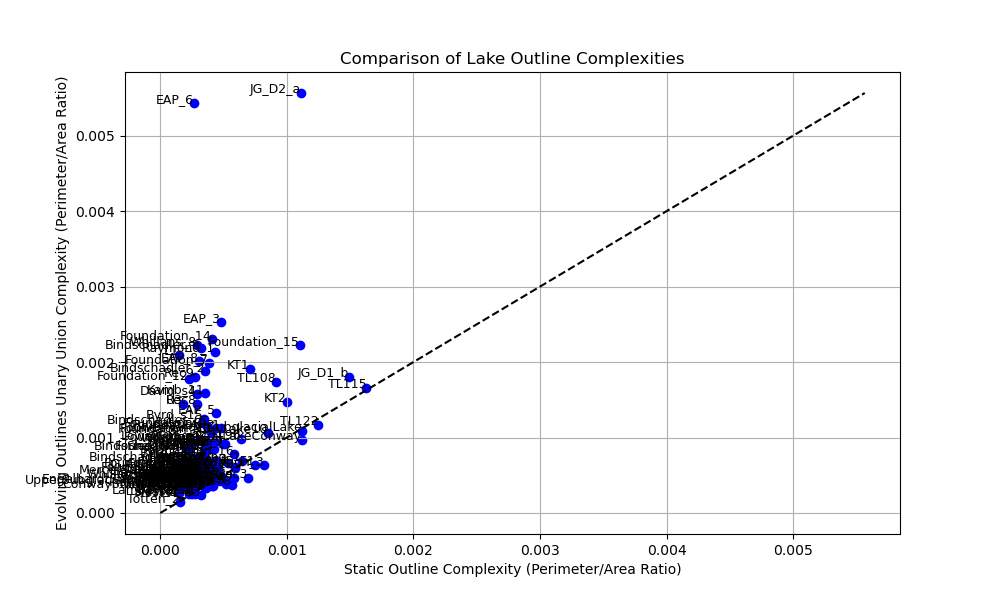

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df['static_complexity'], results_df['evolving_complexity'], color='blue')

# Adding labels for each point
for i, row in results_df.iterrows():
    plt.text(row['static_complexity'], row['evolving_complexity'], row['lake_name'],
             fontsize=9, ha='right')

# Add a 1:1 line
max_complexity = max(results_df['static_complexity'].max(), results_df['evolving_complexity'].max())
plt.plot([0, max_complexity], [0, max_complexity], 'k--', label='1:1 Line')

plt.title('Comparison of Lake Outline Complexities')
plt.xlabel('Static Outline Complexity (Perimeter/Area Ratio)')
plt.ylabel('Evolving Outlines Unary Union Complexity (Perimeter/Area Ratio)')
plt.grid(True)
plt.show()

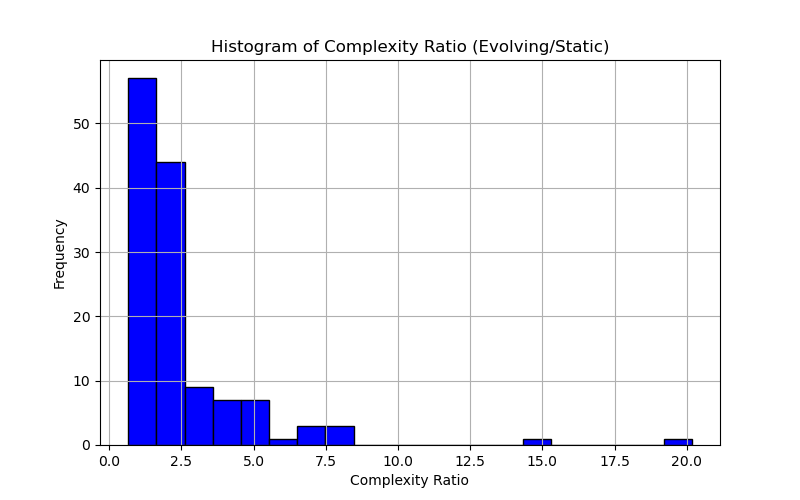

In [37]:
plt.figure(figsize=(8, 5))
plt.hist(results_df['complexity_ratio'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Complexity Ratio (Evolving/Static)')
plt.xlabel('Complexity Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [38]:
summary = results_df['complexity_ratio'].describe(percentiles=[.25, .5, .75])
five_number_summary = {
    'Minimum': summary['min'],
    '25th Percentile': summary['25%'],
    'Median': summary['50%'],
    '75th Percentile': summary['75%'],
    'Maximum': summary['max']
}
print(five_number_summary)

{'Minimum': 0.6573803850422693, '25th Percentile': 1.124860584905735, 'Median': 1.8009403395495445, '75th Percentile': 2.5516313595249325, 'Maximum': 20.174558948474143}


In [29]:
# What percentage of the previously identified lakes have a higher complexity 
count_above = (results_df['evolving_complexity'] > results_df['static_complexity']).sum()
np.round(count_above/len(results_df), 2)

0.85

## Wetted area

In [ ]:
# Main loop to process each lake and store the results in a DataFrame
results = []

for idx, row in static_lakes_gdf.iterrows():
    result = find_max_area_bias(static_lakes_gdf.loc[[idx]])
    if result:
        results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

In [41]:
# What proportion of lakes have an individual time slice area that is larger that the static outline?
neg_count = results_df[results_df['max_bias_area'] < 0].shape[0]
np.round(neg_count/len(results_df), 2)

0.71

In [42]:
# What proportion of lakes have an evolving outlines unary union that is larger that the static outline?
neg_count = results_df[results_df['evolving_union_static_diff'] < 0].shape[0]
np.round(neg_count/len(results_df), 2)

0.59

In [48]:
# What proportion of time slice have an abs(static_outline_region_dh) > abs(evolving_outlines_region_dh) 
# when there is an evolving outline (otherwise rows without evolving outlines with zero for evolving_outlines_region_dh
# would distort proportion

# Filter the DataFrame to include only rows where 'evolving_outlines_region_dh (m)' > 0
filtered_df = all_compare_evolving_and_static_outlines_df[
    all_compare_evolving_and_static_outlines_df['evolving_outlines_region_dh (m)'] > 0]

# Calculate the absolute values for the filtered data
abs_static = abs(filtered_df['static_outline_dh (m)'])
abs_evolving = abs(filtered_df['evolving_outlines_region_dh (m)'])

# Create a boolean series where True indicates abs(static) > abs(evolving)
condition = abs_static > abs_evolving

# Calculate the proportion of True values in the condition
proportion = condition.mean()

print("Proportion of rows where abs(static_outline_dh (m)) > abs(evolving_outlines_region_dh (m)):", np.round(proportion, 2))

Proportion of rows where abs(static_outline_dh (m)) > abs(evolving_outlines_region_dh (m)): 0.78


In [15]:
# Find the five-number summary of the area bias
variable = all_compare_evolving_and_static_outlines_df['bias_area (m^2)']

# Calculate the five-number summary
min_value = np.round(np.nanmin(variable)/1e6, 2)
q1 = np.round(np.nanpercentile(variable, 25)/1e6, 2)
median = np.round(np.nanmedian(variable)/1e6, 2)
q3 = np.round(np.nanpercentile(variable, 75)/1e6, 2)
max_value = np.round(np.nanmax(variable)/1e6, 2)

# Output the five-number summary
print(f"Minimum: {min_value}")
print(f"First quartile (Q1): {q1}")
print(f"Median: {median}")
print(f"Third quartile (Q3): {q3}")
print(f"Maximum: {max_value}")

Minimum: -1257.87
First quartile (Q1): -196.1
Median: -94.01
Third quartile (Q3): -33.15
Maximum: 4355.19


In [17]:
# Finding the index of the maximum value in the 'bias_area (m^2)' column
max_index = all_compare_evolving_and_static_outlines_df['bias_area (m^2)'].idxmax()
min_index = all_compare_evolving_and_static_outlines_df['bias_area (m^2)'].idxmax()

# Retrieving the row with the maximum value
print(all_compare_evolving_and_static_outlines_df.loc[max_index])
# print(all_compare_evolving_and_static_outlines_df.loc[min_index])

midcyc_datetime                      2020-08-16 18:45:00
evolving_outlines_darea (m^2)          5315108651.335535
evolving_outlines_dh (m)                        0.218534
evolving_region_dh (m)                           0.10225
evolving_outlines_dh_corr (m)                   0.116284
evolving_outlines_dvol_corr (m^3)       618064340.451527
static_outline_area                     959920029.875884
static_outline_dh (m)                           0.170722
static_outline_region_dh (m)                    0.159927
static_outline_dh_corr (m)                      0.010795
static_outline_dvol_corr (m^3)           10362019.363085
bias_area (m^2)                        4355188621.459651
bias_region_dh (m)                             -0.057677
bias_outlines_dh_corr (m)                        0.10549
bias_dvol_corr (m^3)                    607702321.088442
lake_name                                        David_1
Name: 1349, dtype: object


In [ ]:
# Replace 'your_folder_path' with the path to your folder containing GeoJSON files
folder_path = '/home/jovyan/1_outlines_candidates/Sauthoff-2024-J.Glaciol./output/lake_outlines/evolving_outlines/*.geojson'
files = glob.glob(folder_path)

levels = []

# Read each GeoJSON file and extract the first 'level' value
for file in files:
    gdf = gpd.read_file(file)
    # Make sure the GeoDataFrame is not empty and contains a 'level' column
    if not gdf.empty and 'level' in gdf.columns:
        first_level_value = gdf.iloc[0]['level']
        levels.append(first_level_value)

# Convert the list of levels to a numpy array for statistical analysis
levels_array = np.array(levels)

# Calculate the five-number summary
min_value = np.min(levels_array)
q1 = np.percentile(levels_array, 25)
median = np.median(levels_array)
q3 = np.percentile(levels_array, 75)
max_value = np.max(levels_array)

# Output the five-number summary
print(f"Minimum: {min_value}")
print(f"First quartile (Q1): {q1}")
print(f"Median: {median}")
print(f"Third quartile (Q3): {q3}")
print(f"Maximum: {max_value}")

## dh_corr

## dvol_corr

In [48]:
# Set the directory where your CSV files are located
folder_path = 'output/lake_outlines/compare_evolving_and_static_outlines'

# List all CSV files in the directory
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Initialize lists to store the results for each condition, both, and either
results_greater_than = []
results_less_than = []
results_both_conditions = []
results_either_condition = []

# Loop through each CSV file
for file in csv_files:
    # Read the CSV file into a DataFrame
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    # Filter out rows where 'evolving_outlines_dvol_corr (m^3)' is 0
    filtered_df = df[df['evolving_outlines_dvol_corr (m^3)'] != 0]

    # Check conditions
    condition_greater_than = (filtered_df['evolving_outlines_dvol_corr (m^3)'] > 1.1 * filtered_df['static_outline_dvol_corr (m^3)'])
    condition_less_than = (filtered_df['evolving_outlines_dvol_corr (m^3)'] < 0.9 * filtered_df['static_outline_dvol_corr (m^3)'])

    # Combined conditions for both and either
    condition_both = condition_greater_than.any() & condition_less_than.any()
    condition_either = condition_greater_than | condition_less_than

    # Append results based on conditions
    results_greater_than.append(condition_greater_than.any())
    results_less_than.append(condition_less_than.any())
    results_both_conditions.append(condition_both.any())
    results_either_condition.append(condition_either.any())

# Calculate the proportion of files that meet each condition
proportion_greater_than = sum(results_greater_than) / len(results_greater_than)
proportion_less_than = sum(results_less_than) / len(results_less_than)
proportion_both_conditions = sum(results_both_conditions) / len(results_both_conditions)
proportion_either_condition = sum(results_either_condition) / len(results_either_condition)

# Print out the results
print(f"Lakes meeting the condition 1 (greater than 110%): {sum(results_greater_than)} ({proportion_greater_than:.2f})")
print(f"Lakes meeting the condition 2 (less than 90%): {sum(results_less_than)} ({proportion_less_than:.2f})")
print(f"Lakes meeting either condition: {sum(results_either_condition)} ({proportion_either_condition:.2f})")
print(f"Lakes meeting both conditions: {sum(results_both_conditions)} ({proportion_both_conditions:.2f})")

Lakes meeting the condition1 (greater than 110%): 119 (0.89%)
Lakes meeting the condition2 (less than 90%): 116 (0.87%)
Lakes meeting either condition: 134 (1.00%)
Lakes meeting both conditions: 101 (0.75%)


In [54]:
# What proportion of all timeslices have evolving outlines dvol greater or less than 10% different from static outline dvol

# Filter out rows where 'evolving_outlines_dvol_corr (m^3)' is 0
filtered_df = all_compare_evolving_and_static_outlines_df[
    all_compare_evolving_and_static_outlines_df['evolving_outlines_dvol_corr (m^3)'] != 0]

# Define the separate conditions
condition1 = (filtered_df['evolving_outlines_dvol_corr (m^3)'].abs() > 
              1.1 * filtered_df['static_outline_dvol_corr (m^3)'].abs())
condition2 = (filtered_df['evolving_outlines_dvol_corr (m^3)'].abs() < 
              0.9 * filtered_df['static_outline_dvol_corr (m^3)'].abs())

# Condition where neither condition is met
either_condition = (condition1 | condition2)

# Condition where neither condition is met
neither_condition = ~(condition1 | condition2)

# Condition where both conditions are met
both_conditions = condition1 & condition2

# Count the number of rows meeting each condition
num_rows_condition1 = condition1.sum()
num_rows_condition2 = condition2.sum()
num_rows_either_condition = either_condition.sum()
num_rows_neither_condition = neither_condition.sum()
num_rows_both_conditions = both_conditions.sum()

# Calculate proportions based on the length of filtered_df
proportion_condition1 = num_rows_condition1 / len(filtered_df)
proportion_condition2 = num_rows_condition2 / len(filtered_df)
proportion_either_condition = num_rows_either_condition / len(filtered_df)
proportion_neither_condition = num_rows_neither_condition / len(filtered_df)
proportion_both_conditions = num_rows_both_conditions / len(filtered_df)  # Conditions are mutually exclusive, so should be zero
sum_of_proportions = np.sum([proportion_condition1, proportion_condition2, proportion_both_conditions, proportion_neither_condition])

# Print out the results
print(f"Proportion of time slices meeting condition 1 (greater than 110%): {np.round(proportion_condition1, 2)}")
print(f"Proportion of time slices meeting condition 2 (less than 90%): {np.round(proportion_condition2, 2)}")
print(f"Proportion of time slices meeting either conditions: {np.round(proportion_either_condition, 2)}")
print(f"Proportion of time slices meeting neither condition: {np.round(proportion_neither_condition, 2)}")
print(f"Proportion of time slices meeting both conditions: {np.round(proportion_both_conditions, 2)}")
print(f"Sums of proportions: {np.round(sum_of_proportions, 2)}")

Proportion of timeslices meeting condition 1 (greater than 110%): 0.37
Proportion of timeslices meeting condition 2 (less than 90%): 0.55
Proportion of timeslices meeting either conditions: 0.92
Proportion of timeslices meeting neither condition: 0.08
Proportion of timeslices meeting both conditions: 0.0
Sums of proportions: 1.0


In [60]:
# What is the distribution of the bias as a percentage of the static outline dvol

# Filter out rows where 'evolving_outlines_dvol_corr (m^3)' is 0
filtered_df = all_compare_evolving_and_static_outlines_df[
    all_compare_evolving_and_static_outlines_df['evolving_outlines_dvol_corr (m^3)'] != 0]

# Assuming filtered_df is already defined as given
# Calculate the percentage of 'bias_dvol_corr (m^3)' relative to 'static_outline_dvol_corr (m^3)'
percentages = (filtered_df['bias_dvol_corr (m^3)'] / filtered_df['static_outline_dvol_corr (m^3)']) * 100

# Calculate the five-number summary of these percentages
five_number_summary = percentages.describe(percentiles=[.25, .5, .75])

# Print the five-number summary
print("Five-number summary of the percentages:")
print(f"Minimum: {five_number_summary['min']:.2f}%")
print(f"25th Percentile: {five_number_summary['25%']:.2f}%")
print(f"Median: {five_number_summary['50%']:.2f}%")
print(f"75th Percentile: {five_number_summary['75%']:.2f}%")
print(f"Maximum: {five_number_summary['max']:.2f}%")

Five-number summary of the percentages:
Minimum: -18391665.72%
25th Percentile: -95.53%
Median: -45.55%
75th Percentile: 17.27%
Maximum: 509441837.87%


# Fig. 2

working on ConwaySubglacialLake


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


working on David_s1


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/io/file.py:383: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


working on Slessor_23


/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


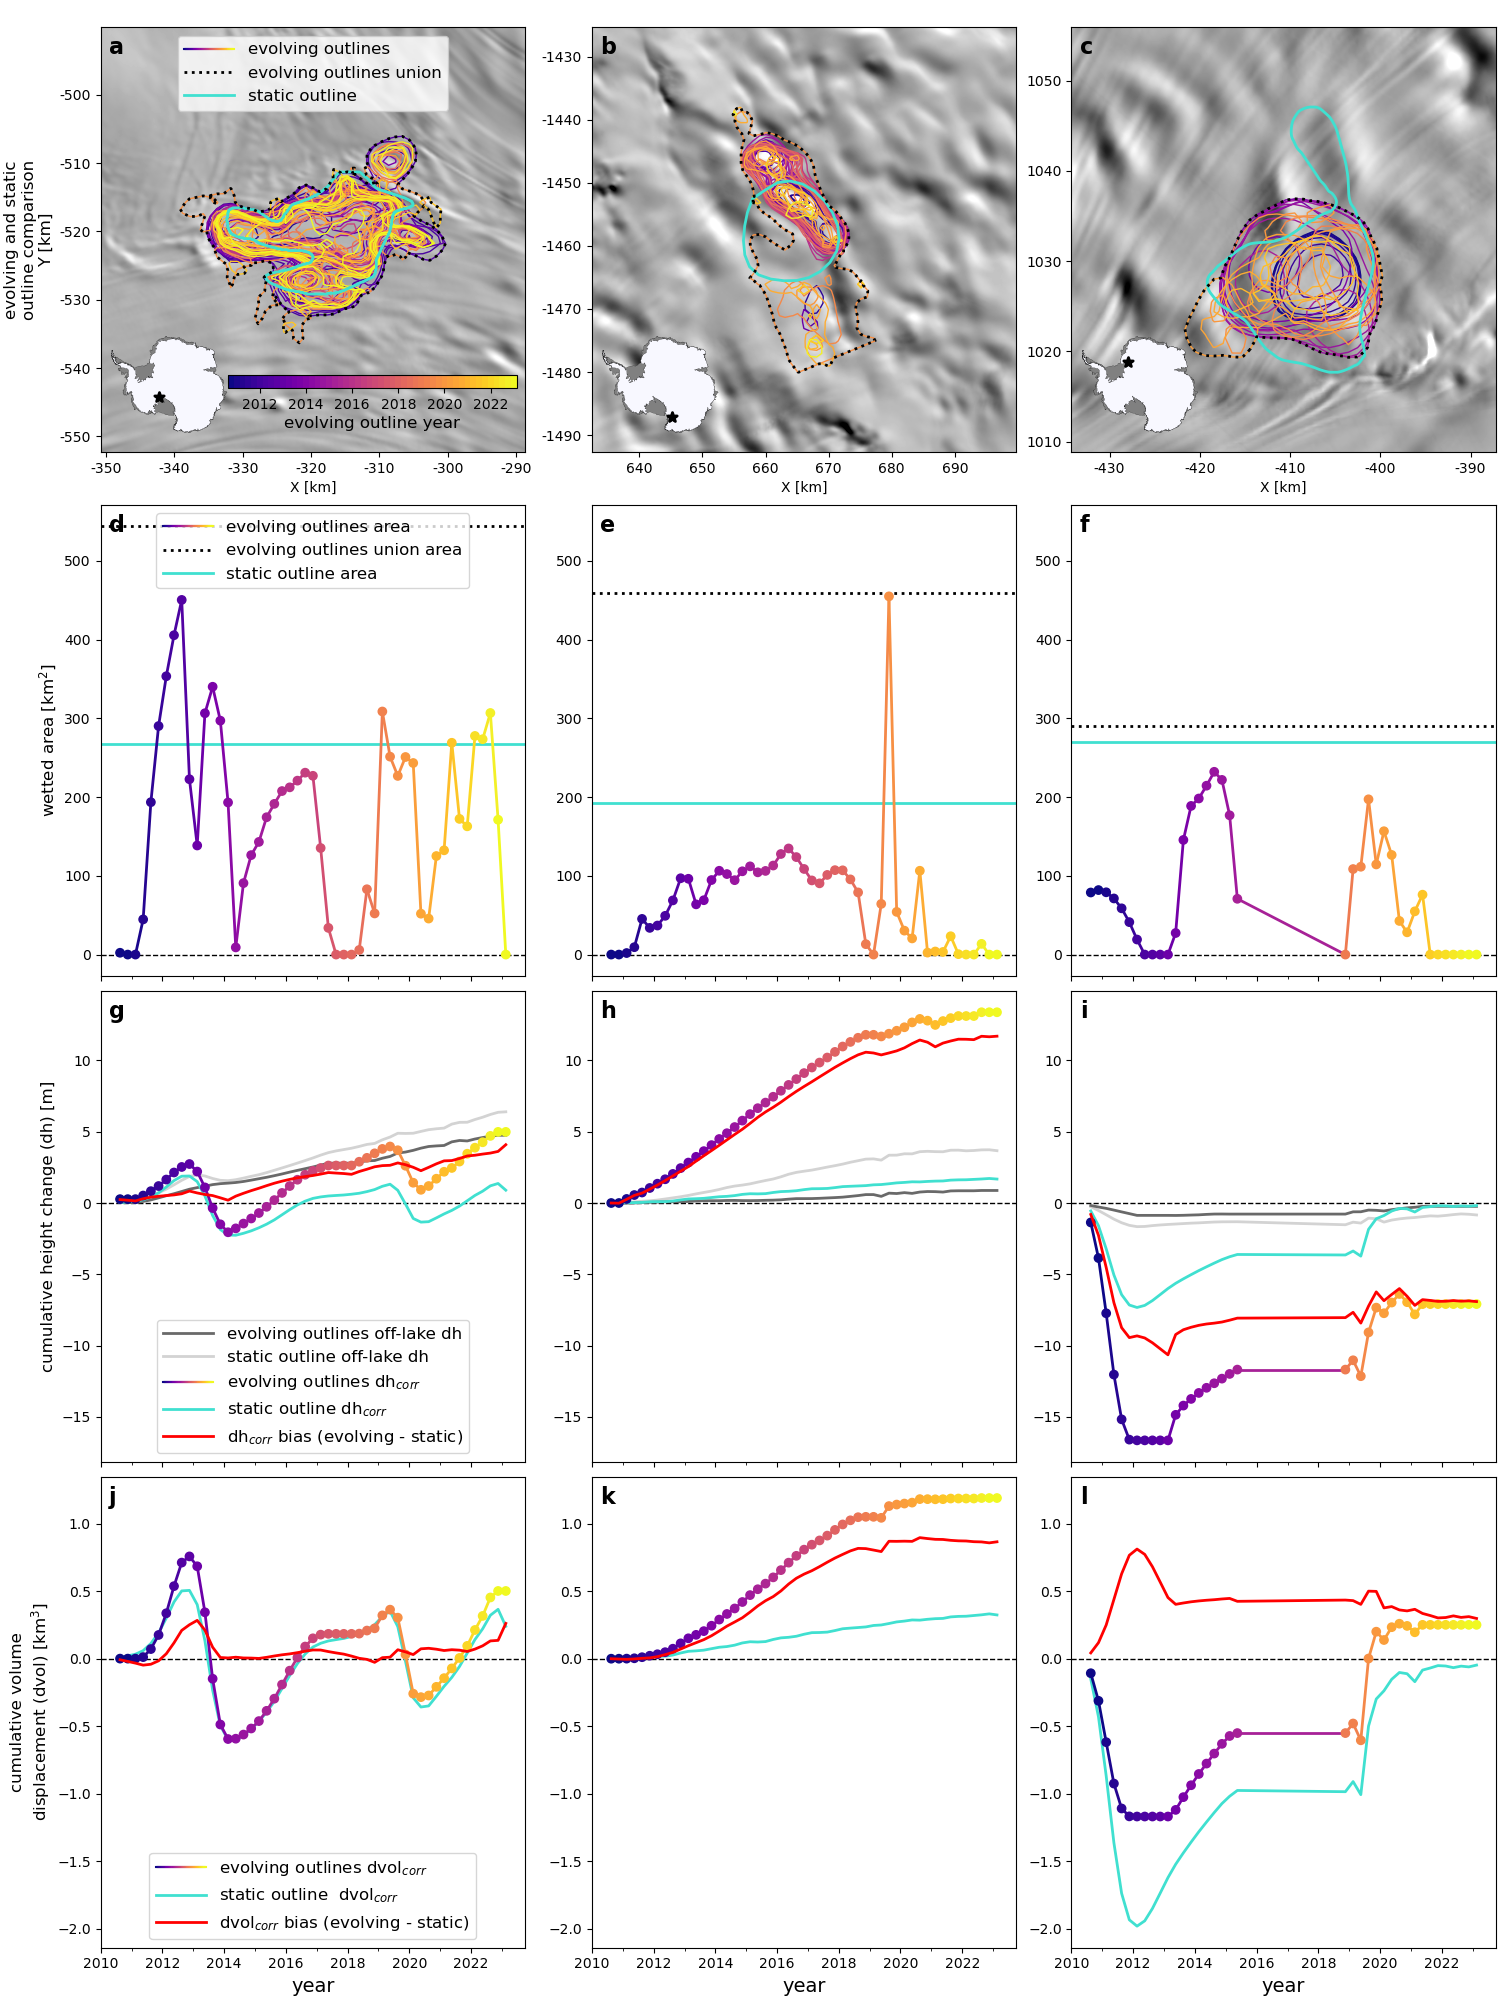

In [87]:
# Select lakes to be included in plot
static_lakes_gdf_filtered = static_lakes_gdf[static_lakes_gdf['name'].isin(['ConwaySubglacialLake', 'David_s1', 'Slessor_23'])]

# Number of rows and columns
nrows, ncols = 4, 3

# Create a 4x3 grid of plots (4 metrics, 3 lakes per metric)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20), constrained_layout=True)

# Define colors and linestyles that will be reused and create lines for legend
static_color  = 'turquoise'
static_linestyle=(0, (1, 1))
static_line = plt.Line2D((0, 1), (0, 0), color=static_color, linestyle='solid', linewidth=2)
unary_union_line = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=2)

for row in range(1, nrows):
    # Share y-axis within each row but not between rows
    for col in range(ncols):
        ax[row, col].sharey(ax[row, 0])

# Pick colormap and make continuous cmap discrete for evolving outlines
colormap = 'plasma'
continuous_cmap = matplotlib.colormaps[colormap]
discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(cyc_dates['midcyc_dates'])-1)))

# Norm to time variable
norm = plt.Normalize(mdates.date2num(cyc_dates['midcyc_dates'].iloc[0]), 
                     mdates.date2num(cyc_dates['midcyc_dates'].iloc[-1]))

for idx, (lake_idx, lake) in enumerate(static_lakes_gdf_filtered.iterrows()):
    # Select the row by index and convert it to a GeoDataFrame
    lake_gdf = static_lakes_gdf_filtered.loc[[lake_idx]]
    lake_name = lake_gdf['name'].iloc[0]
    static_outline = lake_gdf['geometry']
    print('working on {}'.format(lake_name))
    
    # Open static outline(s) and evolving outlines and geometric calculation comparison geodataframes for plotting
    # Attempt to open the evolving outlines GeoJSON file
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except fiona.errors.DriverError:
        print(f"File for {lake_name} not found. Skipping...")
        continue  # Skip the rest of the function if the file doesn't exist
    
    # Attempt to open the geometric calculations CSV file
    try:
        geom_calcs_df = pd.read_csv(os.path.join(
            os.getcwd(), 'output/lake_outlines/compare_evolving_and_static_outlines/{}.csv'.format(lake_name)))
    except FileNotFoundError:
        print(f"CSV file for {lake_name} not found. Skipping...")
        continue  # Skip the rest of the function if the file doesn't exist
    
    # Convert of strings to datetime
    geom_calcs_df['midcyc_datetime'] = pd.to_datetime(geom_calcs_df['midcyc_datetime'])

    
    # Panel - evolving outlines ------------------------------------------------------
    
    # Combine static outline(s) with evolving outlines in unary union to plot all within bounds of plot
    # Use .buffer(0) to fix any invalid geometries
    all_outlines_unary_union = unary_union([lake_gdf['geometry'].iloc[0].buffer(0)] + list(evolving_outlines_gdf.geometry.buffer(0)))
    x_min, y_min, x_max, y_max = all_outlines_unary_union.bounds

    # Make x_min, y_min, x_max, and y_max define a square area centered at the original midpoints
    # Calculate the midpoints of the current bounds
    x_mid = (x_min + x_max) / 2
    y_mid = (y_min + y_max) / 2
    
    # Calculate the current spans of the x and y dimensions
    x_span = x_max - x_min
    y_span = y_max - y_min
    
    # Determine the maximum span to ensure square dimensions
    max_span = max(x_span, y_span)
    
    # Update the min and max values to match the new span, keeping the midpoint the same
    x_min = x_mid - max_span / 2
    x_max = x_mid + max_span / 2
    y_min = y_mid - max_span / 2
    y_max = y_mid + max_span / 2
    
    buffer_frac = 0.3
    x_buffer = abs(x_max-x_min)*buffer_frac
    y_buffer = abs(y_max-y_min)*buffer_frac
    mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
    mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
    
    # Plot static and evolving outlines onto MOA surface imagery
    moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
    ax[0,idx].imshow(moa_highres_da_subset[0,:,:], cmap='gray', clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])
    
    # Pick colormap and make continuous cmap discrete for evolving outlines
    colormap = 'plasma'
    continuous_cmap = matplotlib.colormaps[colormap]
    discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(cyc_dates['midcyc_dates'])-1)))
    
    # Norm to time variable
    norm = plt.Normalize(mdates.date2num(cyc_dates['midcyc_dates'].iloc[0]), 
                         mdates.date2num(cyc_dates['midcyc_dates'].iloc[-1]))
    
    # Use for loop to store each time slice as line segment to use in legend
    # And plot each evolving outline in the geodataframe color by date
    lines = []  # list of lines to be used for the legend
    for dt_idx, dt in enumerate(cyc_dates['midcyc_dates']):
        x = 1; y = 1
        line, = ax[0,idx].plot(x, y, color=discrete_cmap(norm(mdates.date2num(cyc_dates['midcyc_dates'][dt_idx]))))
        lines.append(line)
        
        # Filter rows that match the current time slice
        evolving_outlines_gdf_dt_sub = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
    
        # Plotting the subset if not empty
        if not evolving_outlines_gdf_dt_sub.empty:
            evolving_outlines_gdf_dt_sub.boundary.plot(ax=ax[0,idx], 
                color=discrete_cmap(norm(mdates.date2num(cyc_dates['midcyc_dates'][dt_idx]))), linewidth=1)
    
    # Plot static outline
    lake_gdf['geometry'].boundary.plot(ax=ax[0,idx], color=static_color, linewidth=2)

    # Create evolving outlines unary union and plot
    evolving_outlines_unary_union = unary_union(list(evolving_outlines_gdf.geometry))
    evolving_outlines_unary_union_gdf = gpd.GeoDataFrame(geometry=[evolving_outlines_unary_union], crs='3031')
    evolving_outlines_unary_union_gdf.boundary.plot(ax=ax[0,idx], color='k', linestyle='dotted', linewidth=2)

    # Convert GeoDataFrame to EPSG:4326 for geodesic area calculation
    evolving_outlines_unary_union_gdf = evolving_outlines_unary_union_gdf.to_crs('4326')
    
    # Calculate the geodesic area for each polygon
    evolving_outlines_unary_union_gdf['area (m^2)'] = evolving_outlines_unary_union_gdf['geometry'].apply(calculate_area)

    # Plot inset map
    axIns = ax[0,idx].inset_axes([0.01, 0.01, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.axis('off')
    
    # Plot red star to indicate location
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=2, color='k', s=50, zorder=3)

    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax[0,idx].xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax[0,idx].yaxis.set_major_formatter(ticks_y)
    
    # Set axes limits and labels
    ax[0,idx].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
    ax[0,idx].set_xlabel('X [km]')
    if idx == 0:
        ax[0,idx].set_ylabel('Y [km]')

    
    # Panel - da/dt ---------------------------------------------
    
    # Plot horizontal zero line for reference
    ax[1,idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot static outline and evolving outlines unary union areas
    ax[1,idx].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, color=static_color, linestyle='solid', linewidth=2)
    ax[1,idx].axhline(np.divide(evolving_outlines_unary_union_gdf['area (m^2)'], 1e6).values, color='k', linestyle='dotted', linewidth=2)

    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y=np.divide(geom_calcs_df['evolving_outlines_area (m^2)'], 1e6)
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
    lc.set_linewidth(2)
    line = ax[1,idx].add_collection(lc)
    scatter = ax[1,idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I get legend line to work

    # Format the x-axis to display years only
    ax[1,idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[1,idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[1,idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    
    # Panel - dh/dt -------------------------------------------------------
    
    # Plot horizontal zero line for reference
    ax[2,idx].axhline(0, color='k', linestyle='dashed', linewidth=1)

    # Plot static outlines off-lake region dh
    ax[2,idx].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['static_outline_region_dh (m)']), color='lightgray', linestyle='solid', linewidth=2)

    # Plot evolving outlines off-lake region dh
    ax[2,idx].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['evolving_outlines_region_dh (m)']), color='dimgray', linestyle='solid', linewidth=2)

    # Plot static outline time series
    ax[2,idx].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.cumsum(geom_calcs_df['static_outline_dh_corr (m)']), color=static_color, linestyle='solid', linewidth=2)

    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y=np.cumsum(geom_calcs_df['evolving_outlines_dh_corr (m)'])
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[2,idx].add_collection(lc)
    scatter = ax[2,idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I can figure out how to put in legend

    # Plot bias
    ax[2,idx].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
        np.cumsum(geom_calcs_df['bias_outlines_dh_corr (m)']), color='red', linestyle='solid', linewidth=2)
    
    # Format the x-axis to display years only
    ax[2,idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[2,idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[2,idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years

    
    # Panel - dvol/dt --------------------------------------------------
    
    # Plot horizontal line at zero for reference
    ax[3,idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot static outline time series
    ax[3,idx].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']), 
        np.divide(np.cumsum(geom_calcs_df['static_outline_dvol_corr (m^3)']), 1e9), 
        color=static_color, linestyle='solid', linewidth=2)
    
    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(geom_calcs_df['midcyc_datetime'])
    y=np.cumsum(np.divide(geom_calcs_df['evolving_outlines_dvol_corr (m^3)'], 1e9))
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[3,idx].add_collection(lc)
    scatter = ax[3,idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)
    
    # Plot bias
    ax[3,idx].plot(mdates.date2num(geom_calcs_df['midcyc_datetime']),
        np.cumsum(np.divide(geom_calcs_df['bias_dvol_corr (m^3)'], 1e9)), color='red', linestyle='solid', linewidth=2)
    
    # Format the x-axis to display years only
    ax[3,idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[3,idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[3,idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years

# Add colorbar, legends, and titles
idx=0  # Add colorbar and legends only to first row of plots

# Create colorbar
m = plt.cm.ScalarMappable(cmap=discrete_cmap)
m.set_array(np.array([mdates.date2num(date) for date in cyc_dates['midcyc_dates']]))
cax = inset_axes(ax[0,idx],
                 width='68%',
                 height='3%',
                 loc='lower left',
                 bbox_to_anchor=[0.3,0.15,1,1],  # [left, bottom, width, height]
                 bbox_transform=ax[0,idx].transAxes,
                 borderpad=0,
                 )
# Define years and convert to matplotlib date numbers
years = [2012, 2014, 2016, 2018, 2020, 2022]
year_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in years]
cbar=fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_ticks(year_dates)  # Set ticks to the dates corresponding to the beginning of each year
cbar.set_ticklabels(years)  # Set tick labels as years
cbar.set_label('evolving outline year', size=12, labelpad=3)

# Add legend
legend = ax[0,idx].legend([tuple(lines), unary_union_line, static_line], 
    ['evolving outlines',
     'evolving outlines union',
     'static outline'],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=12, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# Add legend
legend = ax[1,idx].legend([tuple(lines), unary_union_line, static_line],
    ['evolving outlines area', 
     'evolving outlines union area', 
     'static outline area'], 
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=12, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# Add legend
evolving_region = plt.Line2D((0, 1), (0, 0), color='dimgray', linestyle='solid', linewidth=2)
static_region = plt.Line2D((0, 1), (0, 0), color='lightgray', linestyle='solid', linewidth=2)
bias = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)
legend = ax[2,idx].legend(
    [evolving_region,
     static_region,
     tuple(lines),
     static_line,  
     bias],
    ['evolving outlines off-lake dh',
     'static outline off-lake dh',
     'evolving outlines dh$_{corr}$',
     'static outline dh$_{corr}$', 
     'dh$_{corr}$ bias (evolving - static)'],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=12, loc='lower center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# Add legend
legend = ax[3,idx].legend([tuple(lines), static_line, bias],
    ['evolving outlines dvol$_{corr}$', 
     'static outline  dvol$_{corr}$',
     'dvol$_{corr}$ bias (evolving - static)'], 
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=12, loc='lower center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# Set titles
ax[0,idx].set_ylabel('evolving and static\noutline comparison\nY [km]', size=12)
ax[1,idx].set_ylabel('wetted area [km$^2$]', size=12)
ax[2,idx].set_ylabel('cumulative height change (dh) [m]', size=12)
ax[3,idx].set_ylabel('cumulative volume\ndisplacement (dvol) [km$^3$]', size=12)

# Set x-axis labels on upper rows to be blank and labels on lowest row
for idx in range(0,4):
    if idx in [1, 2]:
        for idx2 in [0, 1, 2]:
            ax[idx,idx2].set_xticklabels([])
    if idx==3:
        for idx2 in [0, 1, 2]:
            ax[idx,idx2].set_xlabel('year', size=14)

# Adding annotations 'a', 'b', 'c', etc. at the top left of the subplot
for i, ax_i in enumerate(ax.flatten()):
    # `transform=ax.transAxes` makes coordinates relative to the axes (0,0 is bottom left and 1,1 is top right)
    ax_i.text(0.02, 0.98, chr(97 + i), transform=ax_i.transAxes, fontsize=16, weight='bold', va='top', ha='left')

# Save and close plot
plt.savefig(OUTPUT_DIR + 'Fig2_lake_reexamination_results.png',
    dpi=300, bbox_inches='tight')

# Fig. 3

In [50]:
pole_hole_poly = Polygon([
    (pole_hole_center.x, pole_hole_center.y + 2),
    (pole_hole_center.x, pole_hole_center.y + 2),
    (pole_hole_center.x, pole_hole_center.y + 2),
    (pole_hole_center.x, pole_hole_center.y + 2)
])

list(pole_hole_poly.exterior.coords)

[(0.0, -88.0), (0.0, -88.0), (0.0, -88.0), (0.0, -88.0)]

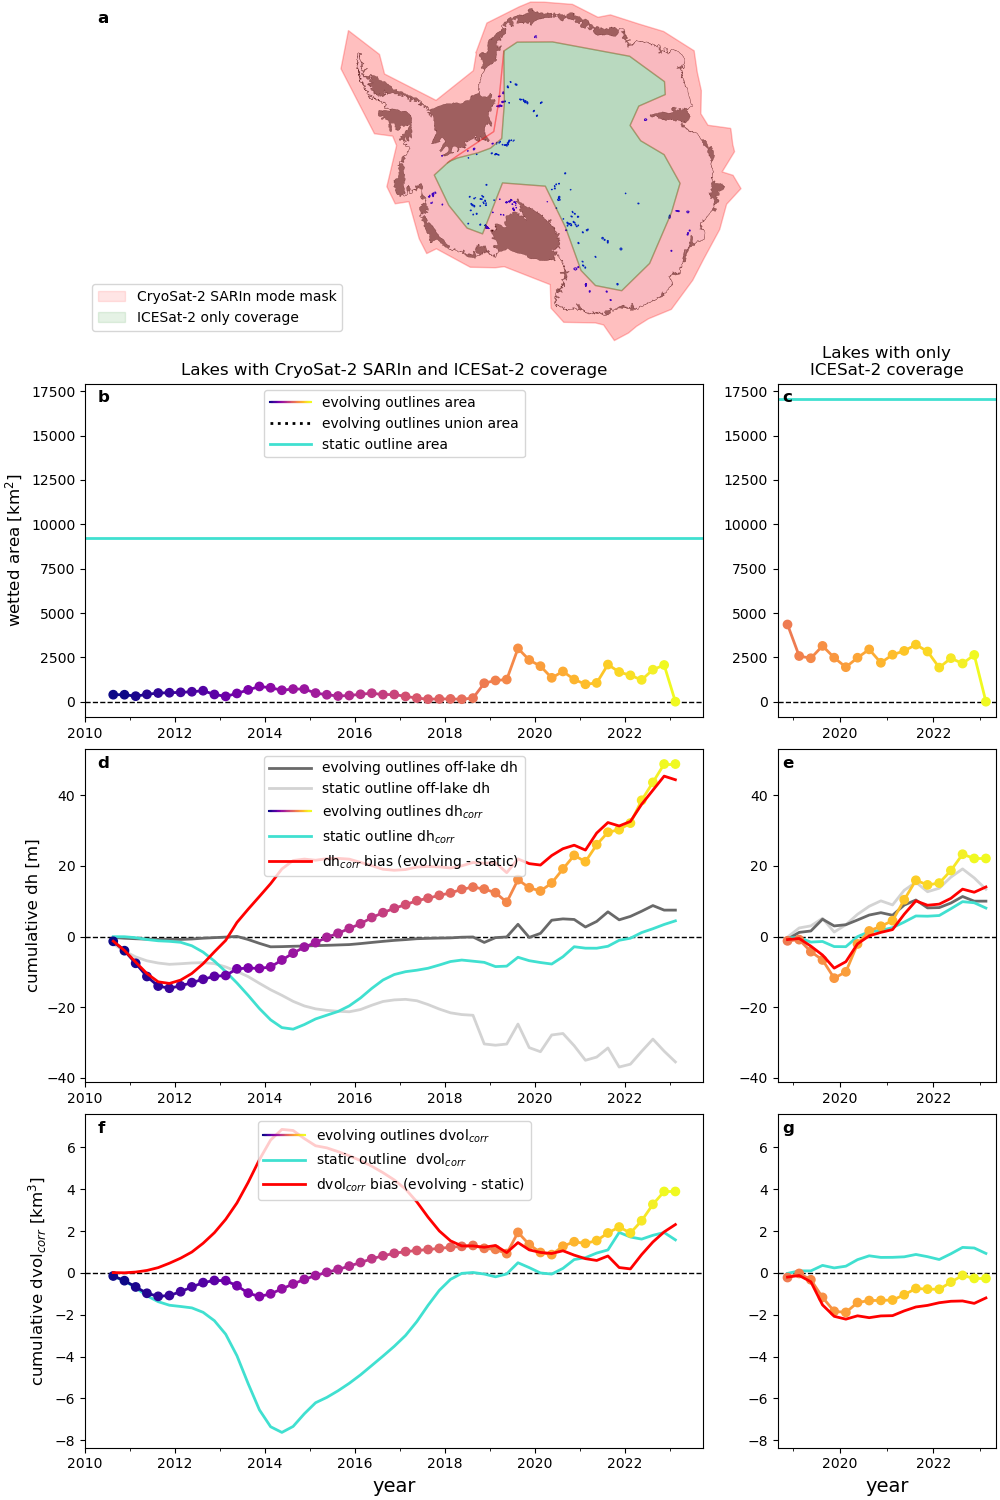

In [16]:
# Number of rows and columns
nrows, ncols = 4, 2

# Create a 3x2 grid of plots (three metrics, two time periods)
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 15))
fig = plt.figure(figsize=(10, 15), constrained_layout=True)

# Create GridSpec with different widths for each column
CS2_IS2_time = len(all_CS2_IS2_lakes_spatially_integrated_df['midcyc_datetime'])
IS2_time = len(all_IS2_lakes_spatially_integrated_df['midcyc_datetime'])
width_ratios = [CS2_IS2_time, IS2_time]
gs = GridSpec(nrows, ncols, figure=fig, width_ratios=width_ratios)  # Width ratio 2:1 between the first and second column

# Creating subplots according to the GridSpec
ax = [[fig.add_subplot(gs[row, col]) for col in range(ncols)] for row in range(nrows)]

# For code compactness and readability
dfs = [all_CS2_IS2_lakes_spatially_integrated_df, all_IS2_lakes_spatially_integrated_df]

# Define colors and linestyles that will be reused and create lines for legend
static_color  = 'turquoise'
static_linestyle=(0, (1, 1))
static_line = plt.Line2D((0, 1), (0, 0), color=static_color, linestyle='solid', linewidth=2)
unary_union_line = plt.Line2D((0, 1), (0, 0), color='k', linestyle='dotted', linewidth=2)

for row in range(nrows):
    # Share y-axis within each row but not between rows
    for col in range(1, ncols):
        ax[row][col].sharey(ax[row][0])

# Pick colormap and make continuous cmap discrete for evolving outlines
colormap = 'plasma'
continuous_cmap = matplotlib.colormaps[colormap]
discrete_cmap = colors.ListedColormap(continuous_cmap(np.linspace(0, 1, len(cyc_dates['midcyc_dates'])-1)))

# Norm to time variable
norm = plt.Normalize(mdates.date2num(cyc_dates['midcyc_dates'].iloc[0]), 
                     mdates.date2num(cyc_dates['midcyc_dates'].iloc[-1]))

# Use for loop to store each time slice as line segment to use in legend
lines = []  # list of lines to be used for the legend
for dt_idx, dt in enumerate(cyc_dates['midcyc_dates']):
    x = 1; y = 1
    line, = ax[0][0].plot(x, y, color=discrete_cmap(norm(mdates.date2num(cyc_dates['midcyc_dates'][dt_idx]))))
    lines.append(line)

# Panel - continental plots ---------------------------------------------
ax0 = fig.add_subplot(gs[0, :])  # Second row, span all columns
map_width, map_height = 4.4,4.4
inset_ax = inset_axes(ax0, width=map_width, height=map_height, loc='center')
moa_2014_coastline.plot(ax=inset_ax, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
moa_2014_groundingline.plot(ax=inset_ax, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1)
static_lakes_gdf.boundary.plot(ax=inset_ax, edgecolor='blue', linestyle='solid', linewidth=0.75, zorder=2)
# Plot CryoSat-2 SARIn mode masks
gdf_SARIn_3_1.plot(ax=inset_ax, edgecolor='red', facecolor='red', alpha=0.25, zorder=3)
gdf_SARIn_3_1_3_6_diff.plot(ax=inset_ax, edgecolor='red', facecolor='red', alpha=0.25, zorder=3)

# New polygon from the hole's boundary
CS2_SARIn_union_polygon = unary_union([gdf_SARIn_3_1.geometry[0], gdf_SARIn_3_1_3_6_diff.geometry[0]])
CS2_SARIn_union_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [CS2_SARIn_union_polygon]}, crs='EPSG:3031')
CS2_SARIn_union_gdf = CS2_SARIn_union_gdf.to_crs(epsg=4326)
pole_hole_center = Point(0, -90)  # Geographic South Pole
pole_hole_poly = Polygon([
    (pole_hole_center.x, pole_hole_center.y + 2),
    (pole_hole_center.x, pole_hole_center.y + 2),
    (pole_hole_center.x, pole_hole_center.y + 2),
    (pole_hole_center.x, pole_hole_center.y + 2)
])
IS2_interior_poly = Polygon(shell=list(CS2_SARIn_union_gdf.geometry[0].interiors[0].coords), holes=[pole_hole_poly.exterior.coords])
IS2_interior_gdf = gpd.GeoDataFrame({'id': [1], 'geometry': [IS2_interior_poly]}, crs='EPSG:4326')
IS2_interior_gdf = IS2_interior_gdf.to_crs(epsg=3031)
IS2_interior_gdf.plot(ax=inset_ax, edgecolor='green', facecolor='green', alpha=0.25, zorder=3)

test = gpd.GeoDataFrame({'id': [1], 'geometry': [pole_hole_poly]}, crs='EPSG:4326')
test = test.to_crs(epsg=3031)
test.plot(ax=inset_ax, edgecolor='k', facecolor='k', alpha=0.25, zorder=3)

inset_ax.set_aspect('equal')
inset_ax.axis('off')
ax0.axis('off')

for idx in [0,1]:  # For loop through two columns
    ax[0][idx].axis('off')
    
    # Panel - da/dt ---------------------------------------------
    
    # Plot horizontal line at zero for reference
    ax[1][idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot static outline and evolving outlines unary union areas
    ax[1][idx].axhline(np.divide(dfs[idx]['static_outline_area (m^2)'][0], 1e6), color=static_color, linestyle='solid', linewidth=2)
    # ax[1][idx].axhline(np.divide(evolving_outlines_unary_union_gdf['area (m^2)'], 1e6).values, color='k', linestyle='dotted', linewidth=2)
    
    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(dfs[idx]['midcyc_datetime'])
    y=np.divide(dfs[idx]['evolving_outlines_area (m^2)'], 1e6)
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
    lc.set_linewidth(2)
    line = ax[1][idx].add_collection(lc)
    scatter = ax[1][idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I get legend line to work
    
    # Format the x-axis to display years only
    ax[1][idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[1][idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[1][idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    # Panel - dh/dt -------------------------------------------------------
    
    # Plot horizontal zero line for reference
    ax[2][idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot static outlines off-lake region dh
    ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
        np.cumsum(dfs[idx]['static_outline_region_dh (m)']), color='lightgray', linestyle='solid', linewidth=2)
    
    # Plot evolving outlines off-lake region dh
    ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
        np.cumsum(dfs[idx]['evolving_outlines_region_dh (m)']), color='dimgray', linestyle='solid', linewidth=2)
    
    # Plot static outline time series
    ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
        np.cumsum(dfs[idx]['static_outline_dh_corr (m)']), color=static_color, linestyle='solid', linewidth=2)
    
    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(dfs[idx]['midcyc_datetime'])
    y=np.cumsum(dfs[idx]['evolving_outlines_dh_corr (m)'])
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[2][idx].add_collection(lc)
    scatter = ax[2][idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)  # Scatter if I can figure out how to put in legend
    
    # Plot bias
    ax[2][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']),
        np.cumsum(dfs[idx]['bias_outlines_dh_corr (m)']), color='red', linestyle='solid', linewidth=2)
    
    # Format the x-axis to display years only
    ax[2][idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[2][idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[2][idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    # Panel D - dvol/dt --------------------------------------------------
    
    # Plot horizontal line at zero for reference
    ax[3][idx].axhline(0, color='k', linestyle='dashed', linewidth=1)
    
    # Plot static outline time series
    ax[3][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']), 
        np.divide(np.cumsum(dfs[idx]['static_outline_dvol_corr (m^3)']), 1e9), 
        color=static_color, linestyle='solid', linewidth=2)
    
    # Plot multi-colored line and scatter for data points
    x=mdates.date2num(dfs[idx]['midcyc_datetime'])
    y=np.cumsum(np.divide(dfs[idx]['evolving_outlines_dvol_corr (m^3)'], 1e9))
    
    # Create points and segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a LineCollection, using the discrete colormap and norm
    lc = LineCollection(segments, cmap=discrete_cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[3][idx].add_collection(lc)
    scatter = ax[3][idx].scatter(x, y, c=x, cmap=discrete_cmap, norm=norm, zorder=2)
    
    # Plot bias
    ax[3][idx].plot(mdates.date2num(dfs[idx]['midcyc_datetime']),
        np.cumsum(np.divide(dfs[idx]['bias_dvol_corr (m^3)'], 1e9)), color='red', linestyle='solid', linewidth=2)
    
    # Format the x-axis to display years only
    ax[3][idx].xaxis.set_major_locator(mdates.YearLocator(base=2))  # Major ticks every other year
    ax[3][idx].xaxis.set_minor_locator(mdates.YearLocator(base=1))  # Minor ticks every year
    ax[3][idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display major ticks as years
    
    # Add colorbar, legends, and titles
    ax[3][idx].set_xlabel('year', size=14)

# Add legends
# Creating custom legend entries
CS2_SARIn_patch = mpatches.Patch(edgecolor='red', facecolor='red', alpha=0.1)
IS2_patch = mpatches.Patch(edgecolor='green', facecolor='green', alpha=0.1)

# Create legend
ax[0][0].legend([CS2_SARIn_patch, IS2_patch],
    ['CryoSat-2 SARIn and ICESat-2 coverage', 'Only ICESat-2 coverage'], 
    loc='lower left')

legend = ax[1][0].legend([tuple(lines), unary_union_line, static_line],
    ['evolving outlines area', 
     'evolving outlines union area', 
     'static outline area'],
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=10, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

evolving_region = plt.Line2D((0, 1), (0, 0), color='dimgray', linestyle='solid', linewidth=2)
static_region = plt.Line2D((0, 1), (0, 0), color='lightgray', linestyle='solid', linewidth=2)
bias = plt.Line2D((0, 1), (0, 0), color='red', linestyle='solid', linewidth=2)
legend = ax[2][0].legend(
    [evolving_region,
     static_region,
     tuple(lines),
     static_line,  
     bias],
    ['evolving outlines off-lake dh',
     'static outline off-lake dh',
     'evolving outlines dh$_{corr}$',
     'static outline dh$_{corr}$', 
     'dh$_{corr}$ bias (evolving - static)'],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=10, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

legend = ax[3][0].legend([tuple(lines), static_line, bias],
    ['evolving outlines dvol$_{corr}$', 
     'static outline  dvol$_{corr}$',
     'dvol$_{corr}$ bias (evolving - static)'], 
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    fontsize=10, loc='upper center')  # loc='upper center', bbox_to_anchor=(-0.2, 0.5))

# Set axes titles
ax[1][0].set_ylabel('wetted area [km$^2$]', size=12)
ax[2][0].set_ylabel('cumulative dh [m]', size=12)
ax[3][0].set_ylabel('cumulative dvol$_{corr}$ [km$^3$]', size=12)

# Plot titles for the first two subplots
ax[1][0].set_title('Lakes with CryoSat-2 SARIn and ICESat-2 coverage')
ax[1][1].set_title('Lakes with only\nICESat-2 coverage')
    
# Adding annotations 'a', 'b', 'c' at the top left of the subplot
ax_array = np.array(ax)  # Convert gridspec list of lists into numpy array to use .flatten() method
char_index = 97  # ASCII value for 'a'
for i, ax_i in enumerate(ax_array.flatten()):
    if i == 1:
        continue  # Skip the second element (index 1)
    # `transform=ax.transAxes` makes coordinates relative to the axes (0,0 is bottom left and 1,1 is top right)
    ax_i.text(0.02, 0.98, chr(char_index), transform=ax_i.transAxes, fontsize=12, weight='bold', va='top', ha='left')
    char_index += 1 # Increment the ASCII index to get the next character

# Save and close plot
plt.savefig(OUTPUT_DIR + 'Fig3_lake_reexamination_results_continentally_integrated.png',
    dpi=300, bbox_inches='tight')

In [82]:
plt.close('all')